In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time


@np.vectorize
def spiketemplate(x_seconds):
    # from VS12, https://github.com/volodymyrss/spiacs-duration/blob/master/spikelike.C
	x = x_seconds*20.
	return 5.5*(0.3429/(np.exp(x/0.253)+np.exp(-1*x/0.1)) + \
		   0.003/(np.exp(x/15.)+np.exp(-1*x/0.1)) + \
		   0.003/(np.exp(x/2.)+np.exp(-1*x/0.1)))




import integralclient as ic

# t0 = Time("2023-04-14T08:00:49") # GRB
# t0 = Time("2017-08-17T12:41:06") # GRB
t0 = Time("2022-08-01T10:50:43.17")

lc = ic.get_hk_genlc('ACS', t0.tt.mjd - 51544, 10)


ijd_to_rel_s = lambda ijd: (ijd - t0.tt.mjd + 51544)*24*3600
t_rel_s = ijd_to_rel_s(lc['t_ijd'])
rate = lc['counts'] / 0.05


failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
got AUTH with homefile for integral-limited
https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/8248.4526892824069364/10


In [ ]:
# morphology of GRB-GW is possibly starting from T0, not there

In [2]:
from scipy.integrate import quad

def spikemodel(t, t0, amplitude, bkg):
    return amplitude * spiketemplate(t - t0) + bkg

def spikemodel_integated(t, *params):
    model = lambda x: spikemodel(x, *params)
    return np.array([quad(model, _t - 0.025, _t + 0.025)[0]/0.05 for _t in t])
    
from scipy.stats import norm, poisson

def match(t, counts, *params):
    # return np.sum((lc - spikemodel(t, t0, amplitude, bkg))**2)
    # return np.sum((counts - spikemodel_integated(t, *params))**2)
    # return -poisson(spikemodel_integated(t, *params)).logpmf(counts).sum()
    return ((spikemodel_integated(t, *params) - counts)**2/counts).sum()
    

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from scipy.stats import chi2
chi2(10).pdf(10)

0.08773368488392541

/tmp/ipykernel_1658432/1922880733.py:10: RuntimeWarning: overflow encountered in exp
  return 5.5*(0.3429/(np.exp(x/0.253)+np.exp(-1*x/0.1)) + \
/tmp/ipykernel_1658432/1922880733.py:11: RuntimeWarning: overflow encountered in exp
  0.003/(np.exp(x/15.)+np.exp(-1*x/0.1)) + \
/tmp/ipykernel_1658432/1922880733.py:12: RuntimeWarning: overflow encountered in exp
  0.003/(np.exp(x/2.)+np.exp(-1*x/0.1)))


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 43.0561992470265
       x: [ 1.521e-01  1.340e+03  5.447e+03]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]]
    nfev: 140
[1.52129095e-01 1.34045753e+03 5.44728502e+03]


0.039034507688931054

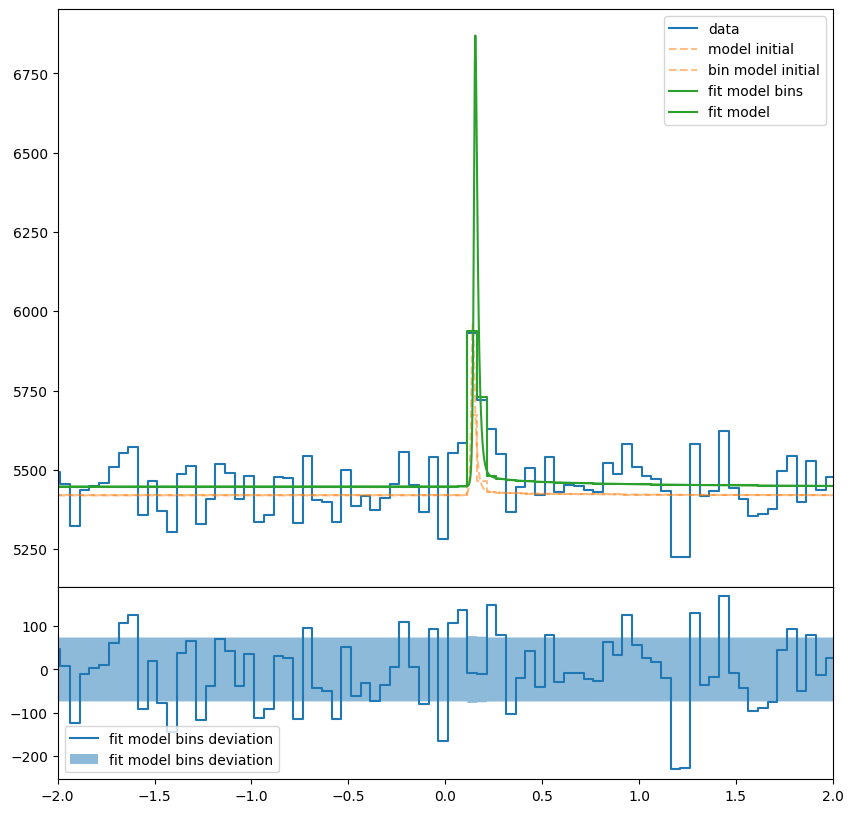

In [4]:
f, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plt.sca(axes[0])

t = np.linspace(-5, 5, 10000)

plt.step(t_rel_s, lc['counts'], where='mid', label='data')


bkg = lc['counts'][t_rel_s<-3].mean()
params = [t_rel_s[lc['counts'].argmax()], lc['counts'].max() - bkg, bkg]

plt.plot(t, spikemodel(t, *params), label='model initial', alpha=0.5, ls='--', color='C1')
plt.step(t_rel_s, spikemodel_integated(t_rel_s, *params), label='bin model initial', where='mid', alpha=0.5, ls='--', color='C1')


m = np.abs(t_rel_s) < 1



from scipy.optimize import minimize

fit = minimize(lambda p: match(t_rel_s[m], lc['counts'][m], *p), 
         params,
        #  method='Nelder-Mead',
         method='Powell',
         )


plt.step(t_rel_s, spikemodel_integated(t_rel_s, *fit.x), label='fit model bins', where='mid', color='C2')
plt.plot(t, spikemodel(t, *fit.x), label='fit model', color='C2')
plt.legend()

plt.sca(axes[1])

model_bins = spikemodel_integated(t_rel_s, *fit.x)

plt.step(t_rel_s, lc['counts'] - model_bins, label='fit model bins deviation', where='mid')
plt.fill_between(t_rel_s, -model_bins**0.5, model_bins**0.5, label='fit model bins deviation', alpha=0.5, step='mid')


plt.subplots_adjust(hspace=0)
print(fit)
print(fit.x)

plt.xlim(-2, 2)
plt.legend()

chi2(np.sum(m)).pdf(fit.fun)